In [1]:
import numpy as np
import pandas as pd
import os
from ast import literal_eval
import matplotlib.pyplot as plt
import skimage as sk

In [2]:
%matplotlib inline

In [3]:
PATH = '../../data/landmarks/'

In [4]:
for file in os.listdir(PATH):
    if '.csv' in file:
        csv_path = PATH + file
        print('Found csv!')
        df = pd.read_csv(csv_path)
        # Remove unproper data (= without 7 labels affected)
        df = df[df['region_count']==7]

Found csv!


In [5]:
df.head()

filename  file_size file_attributes  region_count  region_id  \
0  _ND87877.JPG    9955722              {}             7          0   
1  _ND87877.JPG    9955722              {}             7          1   
2  _ND87877.JPG    9955722              {}             7          2   
3  _ND87877.JPG    9955722              {}             7          3   
4  _ND87877.JPG    9955722              {}             7          4   

                region_shape_attributes region_attributes  
0  {"name":"point","cx":1934,"cy":1110}                {}  
1  {"name":"point","cx":2144,"cy":1484}                {}  
2  {"name":"point","cx":2205,"cy":1633}                {}  
3  {"name":"point","cx":2269,"cy":1487}                {}  
4  {"name":"point","cx":2473,"cy":1092}                {}

In [6]:
print(len(df))

4767


In [7]:
index = df.index
filenames = df.loc[:,'filename']
region_count = df.loc[:,'region_count']
dictionary = [literal_eval(df.loc[:,'region_shape_attributes'][i]) for i in range(len(index))]

In [8]:
# Check if we have 7 indices for each images
df_sum = df.groupby('filename').sum()
df_sum[df_sum['region_count']!=49]

Empty DataFrame
Columns: [file_size, region_count, region_id]
Index: []

In [9]:
print(len(filenames))

4767


In [10]:
print(len(dictionary))

4767


## Compute the bounding boxes

In [9]:
def solve(n, a=1.0, b=1.0, output_shape=(1,1)):
    """
    Arguments:
     -n: image index (times 7 as there are 7 labels per images in the dataset)
     -output_shape 
    Return:
    [[s*cos(theta) -s*sin(theta) tx]
     [s*sin(theta) s*cos(theta)  ty]
     [0            0             1 ]]
    """
    w, h = output_shape
    
    # Here we are in matplotlib coordinate system
    x_6 = dictionary[5+n]['cx'] * a
    y_6 = dictionary[5+n]['cy'] * b
    x_7 = dictionary[6+n]['cx'] * a
    y_7 = dictionary[6+n]['cy'] * b

    x_2 = dictionary[1+n]['cx'] * a
    y_2 = dictionary[1+n]['cy'] * b
    x_4 = dictionary[3+n]['cx'] * a
    y_4 = dictionary[3+n]['cy'] * b

    x_1 = dictionary[0+n]['cx'] * a
    y_1 = dictionary[0+n]['cy'] * b
    x_5 = dictionary[4+n]['cx'] * a
    y_5 = dictionary[4+n]['cy'] * b

    A = np.array([[x_6, -y_6, 1, 0], [y_6, x_6, 0, 1], [x_7, -y_7, 1, 0], [y_7, x_7, 0, 1]])
    b = np.array([w/2.0, h, w/2.0, 0])

#     sol = np.linalg.inv(A.T.dot(A)).dot(A.T.dot(b))

    # Add constraints: the eyes middle point and nose middle points should be in the middle of the picture
    A_c = np.append(A, np.array([[x_1 + x_5, -(y_1 + y_5), 2, 0], [x_2 + x_4, -(y_2 + y_4), 2, 0]]), axis=0)
    b_c = np.append(b, [w, w])

    # Add constraints: the eyes y axis should be equal (eyes are horizontal)
    # y_1 = y_5 => y_1 - y_5 = 0
    A_c = np.append(A_c, np.array([[y_1 - y_5, x_1 - x_5,0,0],[y_2 - y_4, x_2 - x_4,0,0]]), axis=0)
    b_c = np.append(b_c, [0,0])

    sol = np.linalg.inv(A_c.T.dot(A_c)).dot(A_c.T.dot(b_c))
    
    
    return np.array([[sol[0], -sol[1], sol[2]],[sol[1], sol[0], sol[3]], [0,0,1]])

In [47]:
def solve2(n, output_shape=(1,1)):
    """
    (6) and (7) determines the size of the box
    (1),(2),(4),(5) its position and orientation
    Arguments:
     -n: image index (times 7 as there are 7 labels per images in the dataset)
     -output_shape 
    Return:
    [[s*cos(theta) -s*sin(theta) tx]
     [s*sin(theta) s*cos(theta)  ty]
     [0            0             1 ]]
    """
    w, h = output_shape
    
    # Here we are in matplotlib coordinate system
    x_6 = dictionary[5+n]['cx']
    y_6 = dictionary[5+n]['cy']
    x_7 = dictionary[6+n]['cx']
    y_7 = dictionary[6+n]['cy']

    x_2 = dictionary[1+n]['cx']
    y_2 = dictionary[1+n]['cy']
    x_4 = dictionary[3+n]['cx']
    y_4 = dictionary[3+n]['cy']

    x_1 = dictionary[0+n]['cx']
    y_1 = dictionary[0+n]['cy']
    x_5 = dictionary[4+n]['cx']
    y_5 = dictionary[4+n]['cy']

    w_c = 1
    x_c = w_c * (x_2 + x_4)
    y_c = w_c * (y_2 + y_4)

    w_d = 1
    x_d = w_d * (x_1 + x_5)
    y_d = w_d * (y_1 + y_5)
    
    
    A = np.array([[y_6, x_6, 0, 1],[y_7, x_7, 0, 1],[x_c, -y_c, 2*w_c, 0], [x_d, -y_d, 2*w_d, 0]])
    b = np.array([h,0, w_c * w, w_d * w])

    # Add constraints: the eyes y axis should be equal (eyes are horizontal)
    # y_1 = y_5 => y_1 - y_5 = 0
    A_c = np.append(A, np.array([[y_1 - y_5, x_1 - x_5,0,0],[y_2 - y_4, x_2 - x_4,0,0]]), axis=0)
    b_c = np.append(b, [0,0])

    sol = np.linalg.inv(A_c.T.dot(A_c)).dot(A_c.T.dot(b_c))
    
    
    return np.array([[sol[0], -sol[1], sol[2]],[sol[1], sol[0], sol[3]], [0,0,1]])

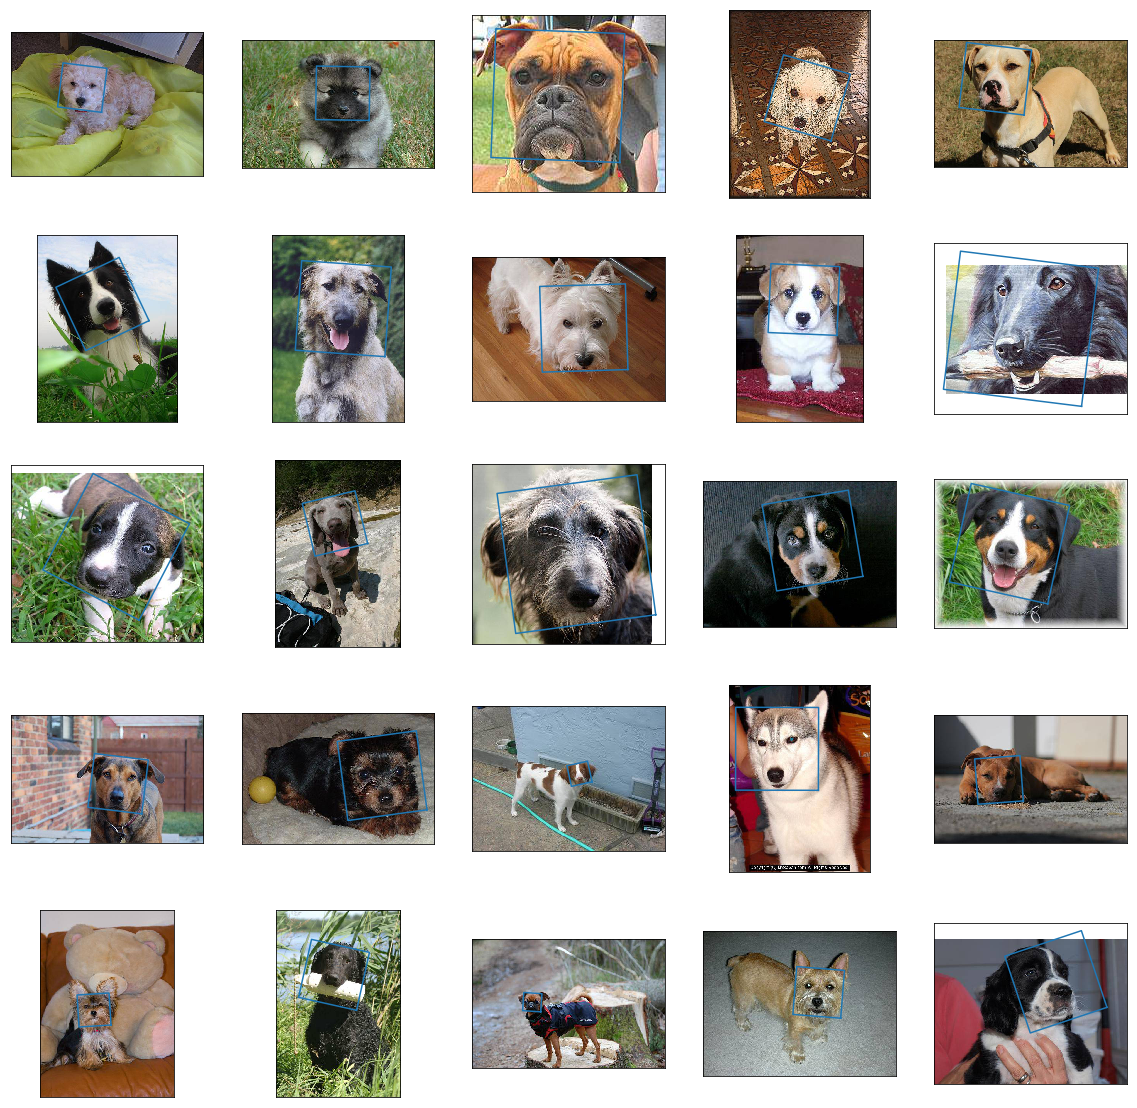

In [10]:
plt.figure(figsize=(20,20))
init = 350
for i in range(init,init+25):
    n = i*7
    plt.subplot(5,5,i-init+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = sk.io.imread(PATH + 'images/' + filenames[n])
    plt.imshow(image, cmap=plt.cm.binary)
    
    M = solve(n)
    P = np.linalg.inv(M)
    bbox_A = P.dot([0,0,1])
    bbox_B = P.dot([1,0,1])
    bbox_C = P.dot([1,1,1])
    bbox_D = P.dot([0,1,1])
    
    plt.plot([bbox_A[0],bbox_B[0],bbox_C[0],bbox_D[0],bbox_A[0]],[bbox_A[1],bbox_B[1],bbox_C[1],bbox_D[1],bbox_A[1]])
    
plt.savefig('bbox.jpg')
    

In [10]:
image = sk.io.imread(PATH + 'images/' + filenames[7*351])
h,w,_=image.shape

print(image.shape)

def frac(h,w,n=5):
    """
    This function takes an image shape as input (h,w) and a integer n. It returns
    the closest image shape (h_out,w_out) of the original one such that h_out < n
    and w_out < n.
    We can then cut the image in h_out*w_out pieces.
    examples:
    frac(500,375,5) returns (4,3)
    frac(333,500,5) returns (2,3)
    """
    fr = float(h)/w
    h_out = 1
    w_out = 1
    if fr > 1:
        for i in range(1,n):
            for j in range(1,i):
                if abs(float(i)/j - fr) < abs(float(h_out)/w_out - fr):
                    h_out = i
                    w_out = j
    else:
        for i in range(1,n):
            for j in range(i,n):
                if abs(float(i)/j - fr) < abs(float(h_out)/w_out - fr):
                    h_out = i
                    w_out = j
    return h_out, w_out

frac(h,w)

(333, 500, 3)


(2, 3)

In [11]:
def vect(u,v):
    """
    "The 2D vectorial product": u ^ v
    """
    return (u[0]*v[1]-u[1]*v[0])

def is_intersect_segment_segment(segment,Segment):
    """
    Check if there is an intersection
    """
    a,b = segment
    A,B = Segment
    aA = A-a
    aB = B-a
    ab = b-a
    
    Aa = a-A
    Ab = b-A
    AB = B-A
    
    return (vect(ab,aA)*vect(ab,aB)<0 and vect(AB,Aa)*vect(AB,Ab)<0)


def intersect_segment_segment(segment,Segment):
    """
    Compute intersection point
    Note: there have to be an intersection, use is_intersect_segment_segment before using this one
    """
    a,b = segment
    A,B = Segment
    Aa = a-A
    AB = B-A
    ab = b-a
    
    M = np.array([AB,-ab]).T
    if np.linalg.det(M)!=0:
        t1,t2 = np.linalg.inv(M).dot(Aa)
        return A + t1*AB

seg = np.array([[0,0],[1,0]])
Seg = np.array([[1.0/3,1],[1+1.0/3,-1]])
print(seg/1.2)
print(is_intersect_segment_segment(seg,Seg))
print(intersect_segment_segment(seg,Seg))


[[0.         0.        ]
 [0.83333333 0.        ]]
True
[0.83333333 0.        ]


In [53]:
def triangle_area(a,b,c):
    """
    Compute area of a triangle given its three summits 2D coordinates
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ab = b-a
    ac = c-a
    return abs(ab[0]*ac[1]-ab[1]*ac[0])/2.0

def quad_area(a,b,c,d):
    return triangle_area(a,b,c) + triangle_area(a,c,d)

def polygone_area(polygone):
    area = 0
    for i in range(1,len(polygone)-1):
        area += triangle_area(polygone[0],polygone[i],polygone[i+1])
    return area

def is_intersect_box_segment(box,segment):
    """
    Check if there is an intersection between the box and the segment
    """
    for i in range(-1,3):
        if is_intersect_segment_segment(np.array([box[i],box[i+1]]),segment):
            return True
    return False

def intersect_box_segment(box,segment):
    """
    Return the intersection point between a box=np.array([a,b,c,d]) and a segment=np.array([A,B])
    Note: there have to be an unique intersection, it uses is_intersect_segment_segment and intersect_segment_segment
    """
    for i in range(-1,3):
        if is_intersect_segment_segment(np.array([box[i],box[i+1]]),segment):
            print(np.array([box[i],box[i+1]]))
            print(segment)
            return intersect_segment_segment(np.array([box[i],box[i+1]]),segment)
    return segment

def is_inside_triangle(triangle,point):
    """
    Returns True if the point is in the triangle
    Returns False if triangle is flat
    """
    # It uses the "barycentre" technique
    a,b,c = triangle
    M = np.array([b-a, c-a]).T
    if np.linalg.det(M)==0:
        return False
    else:
        t = np.linalg.inv(M).dot(point-a)
        return (t[0]>0 and t[0]<1 and t[1]>0 and t[1]<1 and t[0]+t[1]<1)

def is_inside_polygone(polygone,point):
    """
    Returns True if the point is in the polygone
    """
    # We divide the polygone in triangles
    current_index = 1
    is_inside = False
    while not is_inside and current_index < len(polygone)-1:
        triangle = np.array([polygone[0],polygone[current_index],polygone[current_index+1]])
        is_inside = is_inside_triangle(triangle,point)
        current_index += 1
    return is_inside

def intersect_polygone_segment(polygone,segment):
    """
    Return the array of intersection points between "polygone" and "segment".
    "polygone" is a convex polygone.
    """
    intersect = np.empty((0,2))
    current_index = 0
    while len(intersect) < 2 and current_index < len(polygone):
        current_segment = np.array([polygone[current_index-1],polygone[current_index]])
        if is_intersect_segment_segment(current_segment,segment):
            intersect = np.vstack((intersect,[intersect_segment_segment(current_segment,segment)]))
        current_index += 1
    return intersect
        


def intersect_polygone_polygone(Polygone,polygone):
    """
    Compute intersection between two convex polygones.
    They are arrays of points, so of shape (?,2) where ? is the length of the array.
    Its returns the array of points of the intersection convex polygone.
    """
    # intersect is the list of:
    #  -points of polygone that are in Polygone,
    #  -points of Polygone that are in polygone,
    #  -intersection point between edges of box and Box
    # This the points of the intersection of two polygones
    
    # For the first polygone
    in_previous_state = is_inside_polygone(Polygone,polygone[-1])
    if in_previous_state:
        intersect = np.array([polygone[-1]])
    else:
        intersect = np.empty((0,2))
        
    for i in range(len(polygone)):
        in_new_state = is_inside_polygone(Polygone,polygone[i])
        
        # List of intersection points between the full Polygone and a segment of polygone
        # Its lenght has to be between 0 and 2 (because of convex constraint)
        intersect_points = intersect_polygone_segment(Polygone,np.array([polygone[i-1],polygone[i]]))
       
        if in_previous_state==True and in_new_state==True: # len(intersect_points)==0
            intersect = np.vstack((intersect, [polygone[i]]))
        elif in_previous_state==True and in_new_state==False: # len(intersect_points)==1
            intersect = np.vstack((intersect, intersect_points))
        elif in_previous_state==False and in_new_state==True: # len(intersect_points)==1
            intersect = np.vstack((intersect, intersect_points))
            intersect = np.vstack((intersect, [polygone[i]]))
        elif len(intersect_points)==2:
            intersect = np.vstack((intersect, intersect_points))
        
        in_previous_state = in_new_state
    
    # For the second polygone
    for i in range(len(Polygone)):
        if is_inside_polygone(polygone,Polygone[i]):
            intersect = np.vstack((intersect, [Polygone[i]]))

    return intersect

polygone = np.array([[0,0],[1,0],[1,1],[0,1]])
point = np.array([0.25,0.24])
print(is_inside_polygone(polygone,point))
p2 = np.array([1,1])
print(is_inside_polygone(polygone,p2))

segment = np.array([[0.25,0.25],[1.2,1.1]])
print(intersect_polygone_segment(polygone,segment))

poly2 = polygone + np.array([[0.24,0.25]]*len(polygone))
print(is_inside_polygone(polygone,poly2[0]))
intersect = intersect_polygone_polygone(polygone,poly2)
print(intersect)
print(polygone_area(intersect))

True
False
[[1.         0.92105263]]
True
[[0.24 1.  ]
 [0.24 0.25]
 [1.   0.25]
 [1.   1.  ]]
0.5700000000000001


(333, 500, 3)
0.0
0.0
0.6954058022465741
0.30237723324366556
0.0022169645097602697
0.0


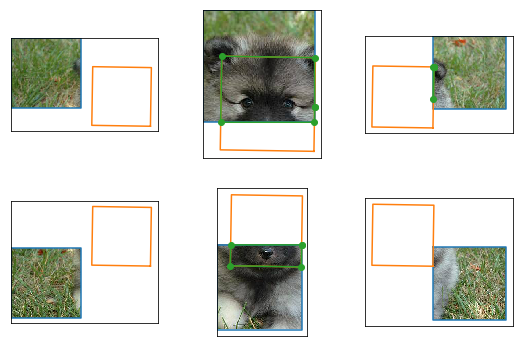

In [54]:
h_out, w_out = frac(h,w)
new_h = h//h_out
new_w = w//w_out
fig = plt.figure(figsize=(w_out*3,h_out*3))


    
    

M = solve(7*351)
P = np.linalg.inv(M)
A = P.dot([0,0,1])
B = P.dot([1,0,1])
C = P.dot([1,1,1])
D = P.dot([0,1,1])

print(image.shape)
    
for i in range(w_out):
    for j in range(h_out):
        plt.subplot(h_out,w_out,i+j*w_out+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_cropped = image[new_h*j:new_h*(j+1),new_w*i:new_w*(i+1),:]
        
        patch = np.array([[new_h*j,new_w*i], [new_h*j,new_w*(i+1)], [new_h*(j+1),new_w*(i+1)], [new_h*(j+1),new_w*i]])
        
        
        # Convert the bbox initially written in matplotlib coord to image coord
        bbox = np.array([[A[1],A[0]],[B[1],B[0]],[C[1],C[0]],[D[1],D[0]]])
        
        inter = intersect_polygone_polygone(patch,bbox)
        
        # Display:
        plt.imshow(image_cropped)
        plt.plot(np.append(patch[:,1],[patch[0][1]]) - np.array([new_w*i]*5),
                 np.append(patch[:,0],[patch[0][0]]) - np.array([new_h*j]*5))
        plt.plot(np.append(bbox[:,1],[bbox[0][1]]) - np.array([new_w*i]*5),
                 np.append(bbox[:,0],[bbox[0][0]]) - np.array([new_h*j]*5))
        print(polygone_area(inter)/polygone_area(bbox))
        if type(inter)!=int and len(inter)>0:
            plt.plot(np.append(inter[:,1],[inter[0][1]]) - np.array([new_w*i]*(len(inter)+1)),
                     np.append(inter[:,0],[inter[0][0]]) - np.array([new_h*j]*(len(inter)+1)),'-o')
        #plt.plot(bbox[:,1] - np.array([new_w*i]*4),bbox[:,0]- np.array([new_h*j]*4))
        

In [17]:
len(np.empty((0,2)))

0

c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


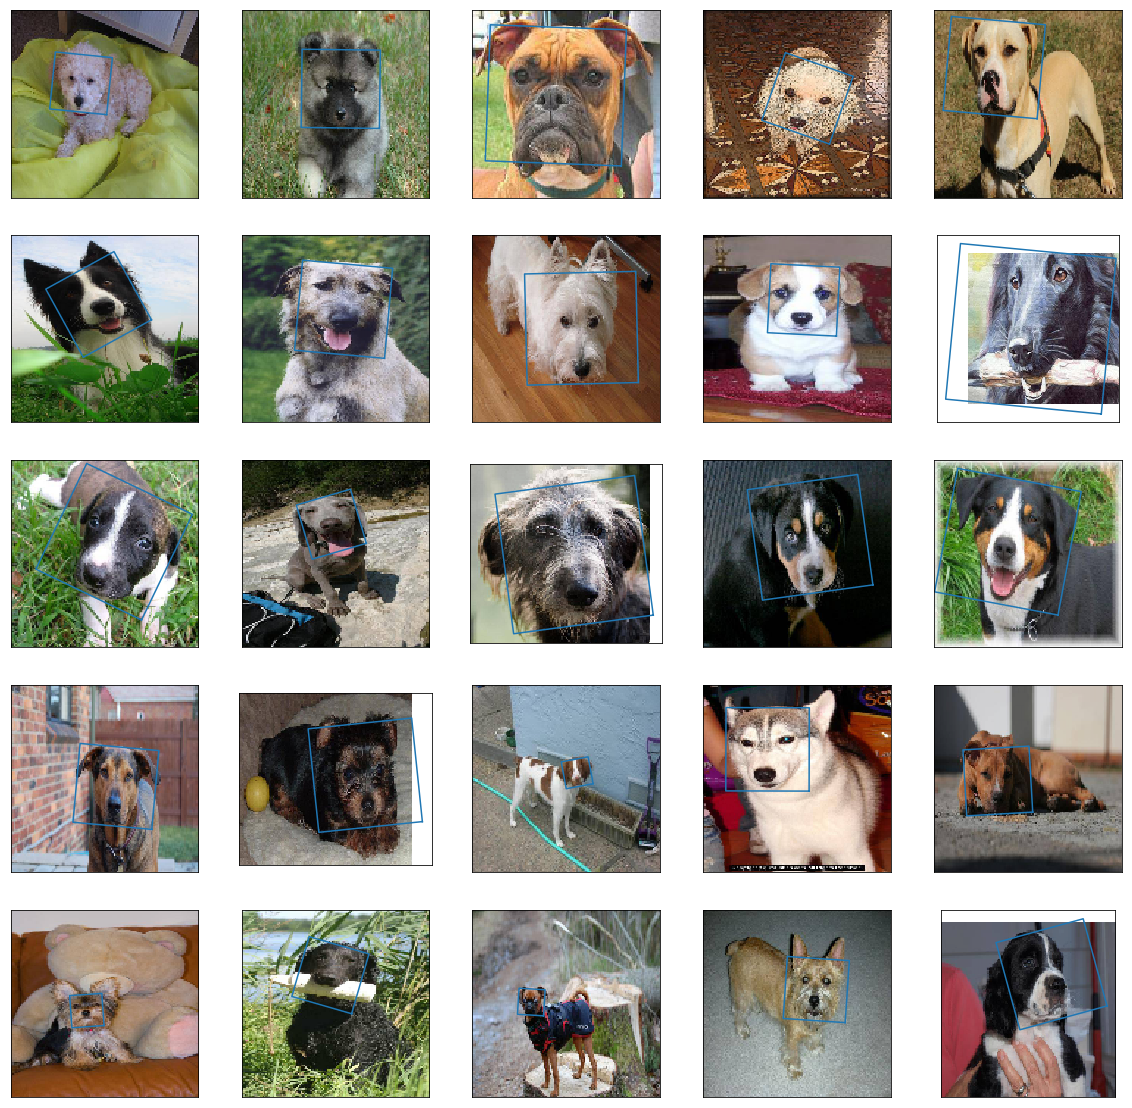

In [16]:
plt.figure(figsize=(20,20))
init = 350
shape = (128,128)
for i in range(init,init+25):
    n = i*7
    plt.subplot(5,5,i-init+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = sk.io.imread(PATH + 'images/' + filenames[n])
    resized_image = sk.transform.resize(image, shape)
    
    plt.imshow(resized_image, cmap=plt.cm.binary)
    
    w_o,h_o,_ = image.shape
    w_r,h_r  = shape
    a = h_r/float(h_o)
    b = w_r/float(w_o)
    
    M = solve(n,a,b)
    P = np.linalg.inv(M)
    bbox_A = P.dot([0,0,1])
    bbox_B = P.dot([1,0,1])
    bbox_C = P.dot([1,1,1])
    bbox_D = P.dot([0,1,1])
    
    plt.plot([bbox_A[0],bbox_B[0],bbox_C[0],bbox_D[0],bbox_A[0]],[bbox_A[1],bbox_B[1],bbox_C[1],bbox_D[1],bbox_A[1]])
    
plt.savefig('bbox.jpg')

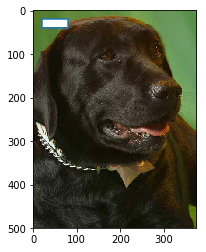

In [11]:
image = sk.io.imread(PATH + 'images/' + filenames[2*7])
for i in range(20,40):
    for j in range(20,80):
        image[i][j] = 255
        
plt.imshow(image)
x = np.array([0,1,1,0,0])*60 + np.ones(5)*20
y = np.array([0,0,1,1,0])*20 + np.ones(5)*20
plt.plot(x,y)
plt.savefig('test.jpg')

# Conclusions:
# for images: matrice like coordinates, so "row" before "column"
# for plot function: "standard" coordinates "abscisse" before "ordinate"
# So: image[i][j] = plot(j,i)

In [12]:
sol = [np.cos(np.pi/4), np.sin(np.pi/4), 1,1]

M = np.array([[sol[0], -sol[1], sol[2]],[sol[1], sol[0], sol[3]], [0,0,1]])

In [13]:
M

array([[ 0.70710678, -0.70710678,  1.        ],
       [ 0.70710678,  0.70710678,  1.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [14]:
x = np.array([1,1,1])
y = M.dot(x)
print(y)

[1.         2.41421356 1.        ]


In [15]:
x

array([1, 1, 1])

In [16]:
A = np.array([[1,2],[3,4]])
b = np.array([1,1])
print(A.T.dot(b))

[4 6]


## Adapt the dataset for training

This method should be independant from the boudning box selection

We will extract the masks from the images and the bounding boxes. These masks are black and white images with 0 and 1: 1 indicates the face location.

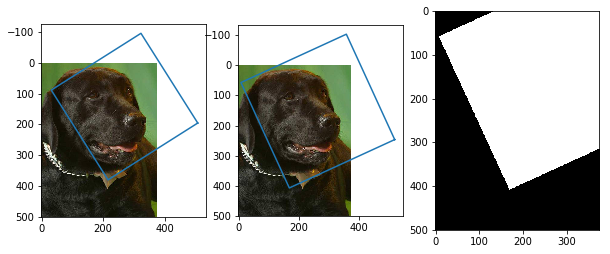

In [10]:
fig = plt.figure(figsize=(10,10))

n = 14

image = sk.io.imread(PATH + 'images/' + filenames[n])

# First plot
plt.subplot(1,3,1)
plt.imshow(image)

M = solve2(n)
P = np.linalg.inv(M)
A = P.dot([0,0,1])
B = P.dot([1,0,1])
C = P.dot([1,1,1])
D = P.dot([0,1,1])

plt.plot([A[0],B[0],C[0],D[0],A[0]],[A[1],B[1],C[1],D[1],A[1]])

# Second plot
plt.subplot(1,3,2)
plt.imshow(image)

M = solve(n)
P = np.linalg.inv(M)
A = P.dot([0,0,1])
B = P.dot([1,0,1])
C = P.dot([1,1,1])
D = P.dot([0,1,1])

plt.plot([A[0],B[0],C[0],D[0],A[0]],[A[1],B[1],C[1],D[1],A[1]])

# Third plot
plt.subplot(1,3,3)
AB = np.array([B[0]-A[0],B[1]-A[1]])
AD = np.array([D[0]-A[0],D[1]-A[1]])

n_ab = np.linalg.norm(AB)**2
n_ad = np.linalg.norm(AD)**2

h,w,c = image.shape

mask = np.zeros(image.shape, dtype=float)

for i in range(h):
    for j in range(w):
        AX = np.array([j-A[0], i-A[1]])
        dot1 = AX.T.dot(AB)/n_ab
        dot2 = AX.T.dot(AD)/n_ad
        if dot1 >= 0 and dot1 <= 1 and dot2 >= 0 and dot2 <= 1:
            mask[i][j] = 1.0


plt.imshow(mask)



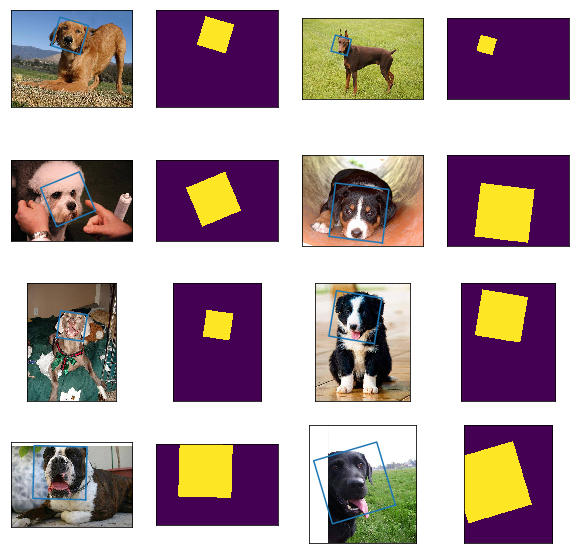

In [49]:
plt.figure(figsize=(10,10))
init = 400
for i in range(init,init+16,2):
    n = i*7
    plt.subplot(4,4,i-init+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = sk.io.imread(PATH + 'images/' + filenames[n])
    plt.imshow(image, cmap=plt.cm.binary)
    
    M = solve2(n)
    P = np.linalg.inv(M)
    A = P.dot([0,0,1])
    B = P.dot([1,0,1])
    C = P.dot([1,1,1])
    D = P.dot([0,1,1])
    
    plt.plot([A[0],B[0],C[0],D[0],A[0]],[A[1],B[1],C[1],D[1],A[1]])
    
    plt.subplot(4,4,i-init+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    AB = np.array([B[0]-A[0],B[1]-A[1]])
    AD = np.array([D[0]-A[0],D[1]-A[1]])

    n_ab = np.linalg.norm(AB)**2
    n_ad = np.linalg.norm(AD)**2

    h,w,c = image.shape

    mask = np.zeros(image.shape[0:2], dtype=float)

    for k in range(h):
        for j in range(w):
            AX = np.array([j-A[0], k-A[1]])
            dot1 = AX.T.dot(AB)/n_ab
            dot2 = AX.T.dot(AD)/n_ad
            if dot1 >= 0 and dot1 <= 1 and dot2 >= 0 and dot2 <= 1:
                mask[k][j] = 1.0


    plt.imshow(mask)
    
    
plt.savefig('mask.jpg')

c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


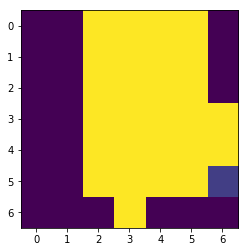

In [46]:
out = sk.transform.resize(mask,(7,7))
plt.imshow(out)

In [51]:
f_mask = os.listdir('../../data/landmarks/masks/')
f_image = os.listdir('../../data/landmarks/resized/')
for f in f_mask:
    if not f in f_image:
        print(f)

Weihnachten 2009 172.jpg


In [6]:
def test(a,t):
    b,c=t
    print(a,b,c)
test(5,(6,7))

5 6 7
